In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from statistics import median
import json
acc_score = od()

In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    for E in c:
        S[E] = np.log(c[E])
        for E1 in c:
            if (E1 > E):
                S[E] += np.log(1 - c[E1])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    for E in c:
        if E in c:
            S[E] = np.log(c[E])
        for E1 in c:
            if (E1 < E):
                S[E] += np.log(1 - c[E1])
    return S

In [44]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    print(name)
    culling_factor = od()
    print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

In [57]:
cool, heat = {
    "q": 3,
    "D": 0.0,
    "L": 32,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 1,
    "heat": False
}, {
    "q": 3,
    "D": 0.0,
    "L": 32,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 1,
    "heat": True
}

for parameters in [cool, heat]:
    parameters = read_files_v2(parameters)

./datasets/2DBlume_q3_D0.000000_N1024_R131072_nSteps10_run1X.txt
1024 131072 10 False
./datasets/2DBlumeHeating_q3_D0.000000_N1024_R131072_nSteps10_run1X.txt
1024 131072 10 True


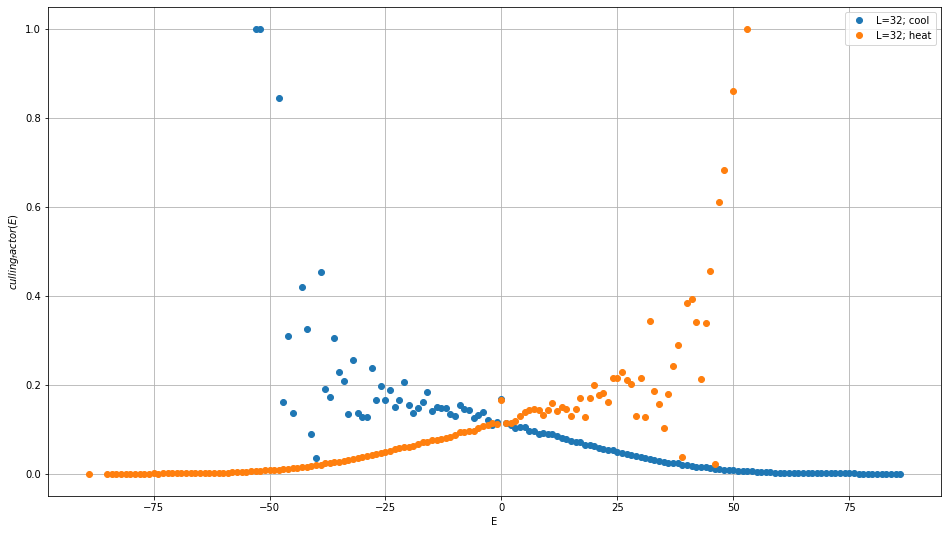

In [46]:
plt.figure(figsize=(16, 9))

plt.plot([E for E in cool["culling_factor"]], [S for E, S in cool["culling_factor"].items()]
         , 'o', label="L={}; cool".format(cool["L"]))
plt.plot([E for E in heat["culling_factor"]], [S for E, S in heat["culling_factor"].items()]
         , 'o', label="L={}; heat".format(heat["L"]))

plt.ylabel("$culling_factor(E)$")d
plt.xlabel("E")
#plt.ylim([-200, -175])
#plt.xlim([-216, -175])
#plt.xlim([-800, -500])
plt.legend()
plt.grid()

In [47]:
def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift    
    return {"S": result, "L": heat["L"]}

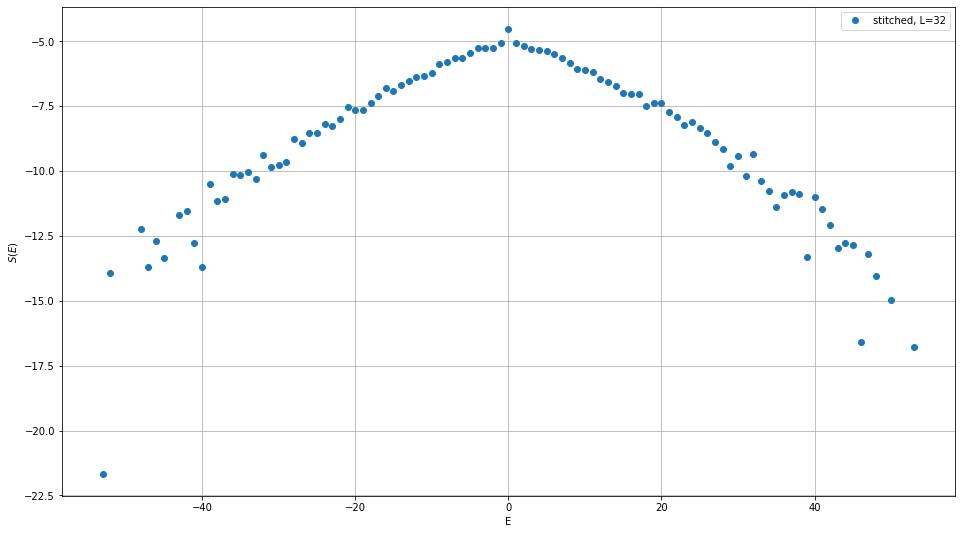

In [48]:
plt.figure(figsize=(16, 9))

st = stitch_S(heat, cool);

plt.plot([E for E in st["S"]],
         [S for E, S in st["S"].items()]
         , 'o', label="stitched, L={}".format(st["L"]))

#plt.ylabel("$g = e^{S(E)}$")
plt.ylabel("$S(E)$")
plt.xlabel("E")
#left
#plt.ylim([-1150, -1050])
#plt.xlim([-2060, -2000])
#middle
#plt.ylim([-100, 10])
#plt.xlim([-900, -500])
#right
#plt.ylim([-800, -200])
#plt.xlim([-100, 10])

plt.legend()
plt.grid()

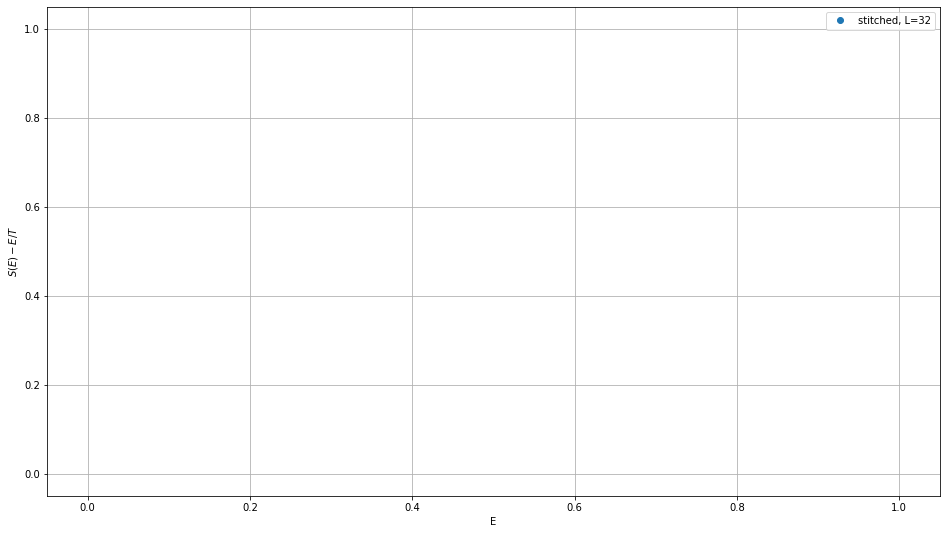

In [49]:
plt.figure(figsize=(16, 9))

T = 0.62

plt.plot([E for E in st["S"]],
         np.exp([S - E / T + 1500 for E, S in st["S"].items()])
         , 'o', label="stitched, L={}".format(st["L"]))

#plt.ylabel("$g = e^{S(E)}$")
plt.ylabel('$S(E) - E / T$')
plt.xlabel("E")
#left
#plt.ylim([-1150, -1050])
#plt.xlim([-2060, -2000])
#middle
#plt.ylim([-100, 10])
#plt.xlim([-900, -500])
#right
#plt.ylim([-800, -200])
#plt.xlim([-100, 10])
#plt.xlim([-1500, -500])
plt.legend()
plt.grid()

In [50]:
hc = {}

In [51]:
L = st['L']
N = L * L
N

1024

In [52]:
import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [53]:
def calc_hc(st, T):
    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    return (avgE_sq - avgE * avgE) / (T * T)


In [54]:
for T in np.linspace(0.1, 2, 20):
    hc[T] = calc_hc(st, T)


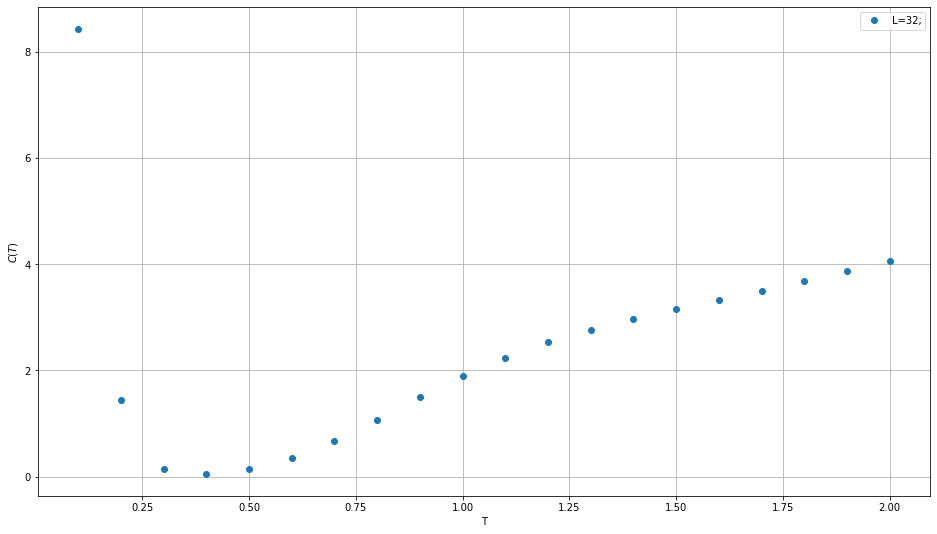

In [55]:
plt.figure(figsize=(16, 9))

plt.plot([T for T in hc],
         [c for T, c in hc.items()]
         , 'o', label='L={};'.format(st['L']))

plt.ylabel('$C(T)$')
plt.xlabel("T")
plt.legend()
plt.grid()

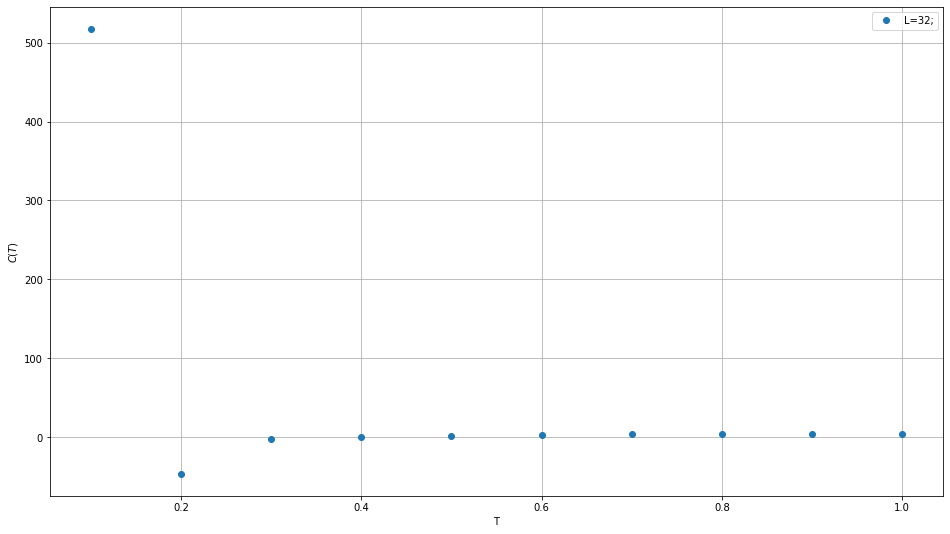

In [41]:
plt.figure(figsize=(16, 9))

plt.plot([T for T in hc],
         [mp.diff(lambda x: calc_hc(st, x), T, n=1) for T in hc]
         , 'o', label='L={};'.format(st['L']))

plt.ylabel('$C(T)$')
plt.xlabel("T")
plt.legend()
plt.grid()

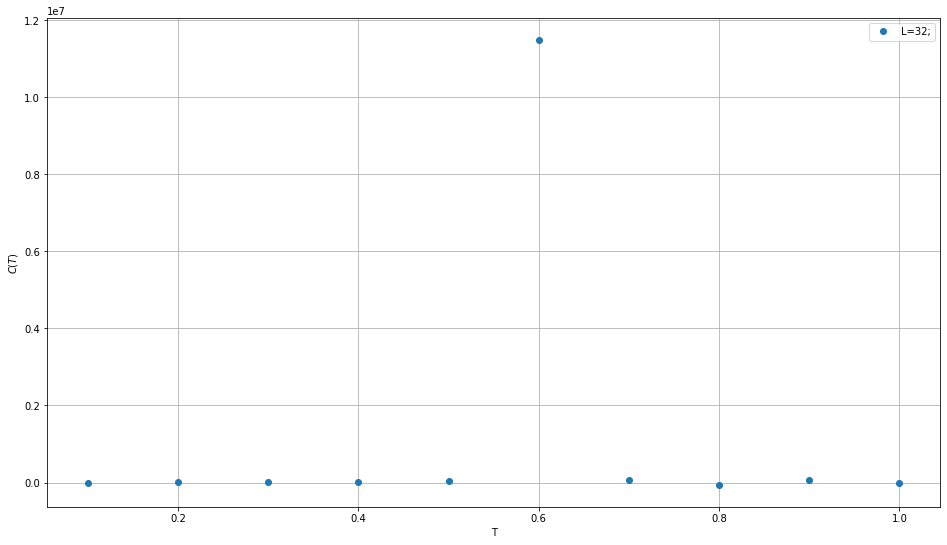

In [29]:
plt.figure(figsize=(16, 9))

plt.plot([T for T in hc],
         [mp.diff(lambda x: calc_hc(st, x), T, n=2) for T in hc]
         , 'o', label='L={};'.format(st['L']))

plt.ylabel('$C(T)$')
plt.xlabel("T")
plt.legend()
plt.grid()